In [2]:
pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
df_train = pd.read_csv('./Corona_NLP_train.csv', encoding = 'latin')
df_test = pd.read_csv('./Corona_NLP_test.csv', encoding = 'latin')

In [5]:
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Text(0.5, 1.0, 'Distribution of sentiment in training data')

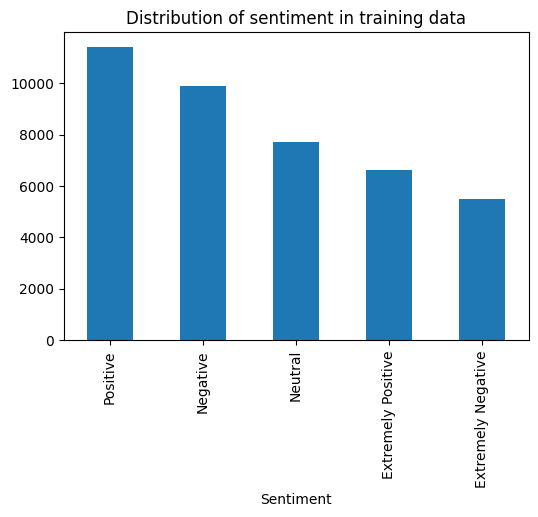

In [6]:
plt.figure(figsize = (6,4))
df_train.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in training data')

In [7]:
x = df_train['OriginalTweet']
y = df_train['Sentiment']

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import nltk
from nltk.corpus import stopwords

In [11]:
import nltk
nltk.download('stopwords')  # Mengunduh resource stopwords

[nltk_data] Downloading package stopwords to C:\Users\USER
[nltk_data]     DK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import re
def text_cleaner(tweet):   
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)  
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])   
    return tweet

stop_words = stopwords.words('english')

X_c = x.apply(text_cleaner)
X_c.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[18]))
print("\nAfter tokenizing :\n{}".format(X[18]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[18]))

Vocabulary size: 36117

Example:

Sentence:
Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries ÂAs COVID- spread, weÂve seen significant increase people shopping online groceries,Â spokeswoman said statement. ÂToday resulted systems impact affecting ...

After tokenizing :
[423, 13610, 13611, 478, 742, 510, 7, 614, 11240, 1, 92, 1936, 262, 1200, 218, 8, 12, 13, 266, 245, 13612, 143, 1740, 9764, 3690, 1651, 107, 1303]

After padding :
[  423 13610 13611   478   742   510     7   614 11240     1    92  1936
   262  1200   218     8    12    13   266   245 13612   143  1740  9764
  3690  1651   107  1303     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [14]:
sentiments = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
y = y.map(sentiments)
labels = ['Negative', 'Neutral', 'Positive']

In [15]:
X_test = df_test['OriginalTweet'].copy()
y_test = df_test['Sentiment'].copy()

X_test = X_test.apply(text_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

In [16]:
def training_plotting_predicting(model, eps, bs, model_name):

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
            
    history = model.fit(X, y, epochs=eps, 
                        validation_split=0.15, batch_size=bs,
                        callbacks = [callback])
    
    hist_model = pd.DataFrame(history.history)
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')
    
    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    CNN_loss, CNN_acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(CNN_loss))
    print('Test Accuracy: {}'.format(CNN_acc))
    
    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])
    
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix of ' + model_name)
    plt.show()
    
    return CNN_acc, cm

In [17]:
embedding_dim = 16
#Input size is 54x1
i= layer.Input(shape=(X.shape[1],),)
x = layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1])(i)

#Output of this next layer is (54-3+1,32) = (52,32)
x = layer.Conv1D(32, 3, activation='relu')(x)
#Output of this next layer is (52/2, 32) = (26,32)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (26-3+1, 64) = (24,64)
x = layer.Conv1D(64, 3, activation='relu')(x)
#Output of this next layer is (24/2, 64) = (12,64)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (12-3+1,128) = (10,128) 
x = layer.Conv1D(128, 3, activation='relu')(x)
#Output of this next layer is (10/2,128) = (5,128)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (1,128) 
x = layer.GlobalMaxPooling1D()(x)
outputs = layer.Dense(3, activation='softmax')(x)
model_1 = tf.keras.Model(i, outputs)
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 54, 16)         │       577,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 52, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,739 (2.33 MB)

 Trainable params: 610,739 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6070 - loss: 0.8095 - val_accuracy: 0.8648 - val_loss: 0.4101
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8973 - loss: 0.3231 - val_accuracy: 0.8709 - val_loss: 0.3786
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9413 - loss: 0.1901 - val_accuracy: 0.8563 - val_loss: 0.4402
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test loss: 0.5153795480728149
Test Accuracy: 0.8388625383377075


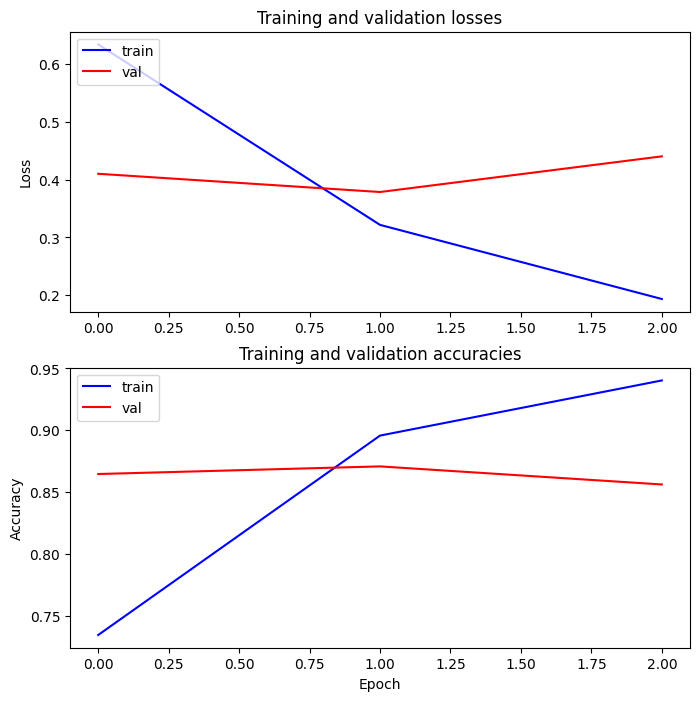

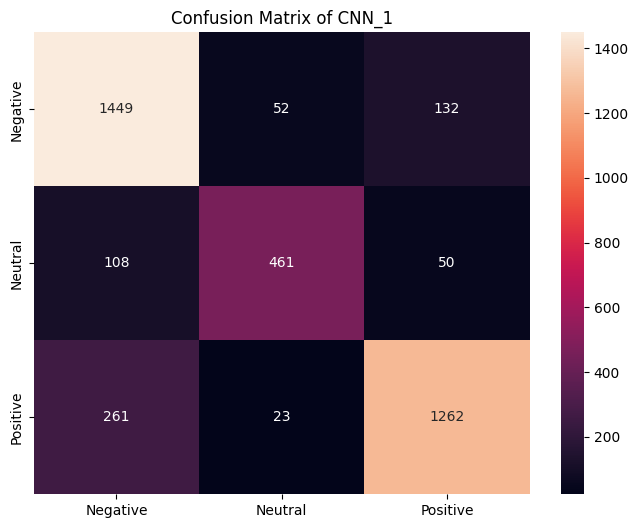

In [18]:
cnn1 = training_plotting_predicting(model_1, 15, 32, 'CNN_1')

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

# Fungsi untuk membuat model dan melatihnya
def create_and_train_model(X_train, y_train, X_val, y_val):
    embedding_dim = 16
    vocab_size = 1000  # Ganti nilai vocab_size sesuai dengan kebutuhan Anda

    # Definisi model
    i = layers.Input(shape=(X_train.shape[1],),)
    x = layers.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1])(i)

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.GlobalMaxPooling1D()(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(i, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callback TensorBoard
    log_dir = "./logs"  # Tentukan direktori log TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Proses pelatihan model dengan menggunakan TensorBoardCallback
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])
    
    return model, history

# Tampilkan TensorBoard di dalam notebook
%load_ext tensorboard
%tensorboard --logdir=./logs



Launching TensorBoard...

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9650 - loss: 0.1197 - val_accuracy: 0.8189 - val_loss: 0.5841
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9814 - loss: 0.0598 - val_accuracy: 0.8189 - val_loss: 0.7743
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test loss: 0.8825809955596924
Test Accuracy: 0.7959452271461487


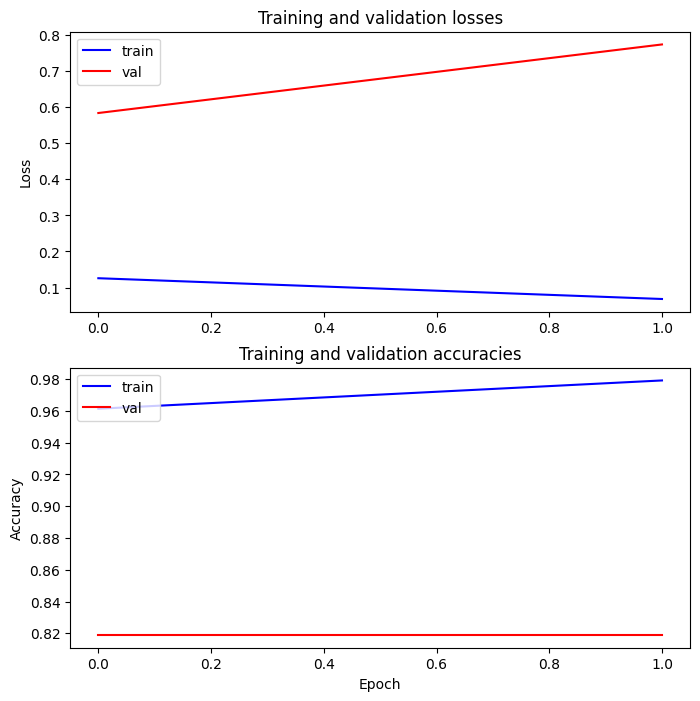

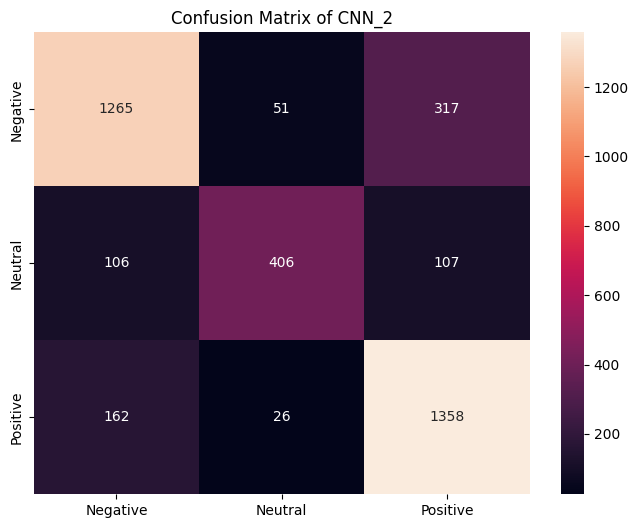

In [20]:
cnn2 = training_plotting_predicting(model_1, 15, 32, 'CNN_2')

In [21]:
model_RNN_acc = 0.828067421913147
model_LSTM_acc = 0.8006845712661743
model_GRU_acc = 0.8104265332221985
model_RNN_G_acc = 0.73854660987854
model_LSTM_G_acc = 0.7580305337905884
model_GRU_G_acc = 0.7472353577613831
model_bLSTM_G_acc = 0.7761979699134827

In [22]:
dc = {'Networks': ['CNN_1', 'CNN_2', 'RNN', 'LSTM', 'GRU', 'RNN_G', 'LSTM_G', 'bLSTM_G', 'GRU_G'], 
      'Accuracy':[cnn1[0], cnn2[0], model_RNN_acc, model_LSTM_acc, model_GRU_acc, model_RNN_G_acc, model_LSTM_G_acc,
                  model_bLSTM_G_acc,model_GRU_G_acc]}
dfc = pd.DataFrame(dc)
dfc2 = dfc.set_index('Networks')

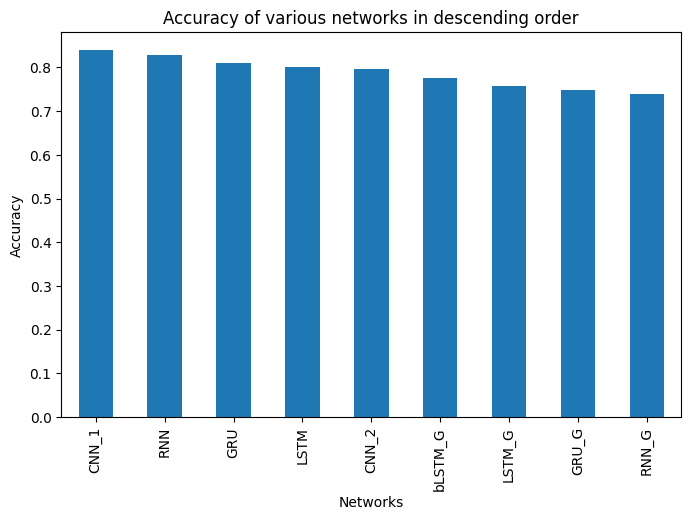

In [23]:
plt.figure(figsize =(8,5))
dfc2['Accuracy'].sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('Accuracy')
plt.title('Accuracy of various networks in descending order');

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

# Definisi model
# ... (kode definisi model lainnya)

# Fungsi untuk membuat model dan melatihnya
def create_and_train_model(X_train, y_train):
    embedding_dim = 16
    vocab_size = 1000  # Ganti nilai vocab_size sesuai dengan kebutuhan Anda

    # Definisi model
    i = layers.Input(shape=(X_train.shape[1],),)
    x = layers.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1])(i)

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.GlobalMaxPooling1D()(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(i, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Latih model
    model.fit(X_train, y_train, epochs=10)  # Sesuaikan epochs dengan kebutuhan Anda

    # Simpan model setelah dilatih
    model.save('model.h5')  # Menyimpan model dengan nama 'model.h5'

    return model

# Contoh data X_train dan y_train (ganti dengan data yang sesuai)
X_train = np.random.rand(100, 10)
y_train = np.random.randint(0, 3, size=(100,))

# Panggil fungsi create_and_train_model
trained_model = create_and_train_model(X_train, y_train)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3709 - loss: 1.0968
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3834 - loss: 1.0935 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3949 - loss: 1.0888 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3782 - loss: 1.0896 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3563 - loss: 1.0969 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4136 - loss: 1.0872 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3918 - loss: 1.0925 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3584 - loss: 1.0965
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3824 - loss: 1.0903
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3428 - loss: 1.0982 
